In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
# import mpld3
# mpld3.enable_notebook()
from matplotlib.colors import LogNorm
plt.close('all')

In [2]:
def getExamplesDf(path):
    df = pd.read_csv(filepath_or_buffer=path, header=None)
    df['id'] = df.index
    df['class'] = df[22]
    return df
examplesDf = getExamplesDf('../../datasets/test.csv')
examplesSize = examplesDf.shape[0]
# examplesDf

In [3]:
def getMatchesDf(path):
    df = pd.read_csv(filepath_or_buffer=path)
    df['id'] = df['#pointId'].astype(int)
    return df;
mfogDF = getMatchesDf('../../out/matches.csv')
minasDF = getMatchesDf('../../out/minas-og/2020-07-20T18-36-59.803/matches.csv')
# matchesDf

In [4]:
def getOriginalMatchesDf(path):
    df = pd.read_table(filepath_or_buffer=path, header=None)
    df.columns=['id', 'class', 'label']
    df = df[df['id'].str.startswith('Ex:')]
    def cleanLabel(text):
        label = text.replace('Classe MINAS:', '').strip()
        if label == 'Unk': return '-'
        if label.startswith('C '): return label.replace('C ', '')
        return label
    return pd.DataFrame({
        'id': df['id'].apply(lambda x: x.replace('Ex:', '').strip()).astype(int) - 1,
        'label': df['label'].apply(cleanLabel),
    })
ogdf = getOriginalMatchesDf('../../out/minas-og/2020-07-20T12-21-54.755/results')
# print(ogdf['label'].unique())
# ogdf

In [5]:
def merge(exDf, maDf):
    def checkCols(df, cols):
        return pd.Series(cols).isin(df.columns).all()
    assert checkCols(exDf, ['id', 'class'])
    assert checkCols(maDf, ['id', 'label'])
    return pd.merge(exDf[['id', 'class']], maDf[['id', 'label']], on='id', how='left')
def confusionMatrix(exDf, maDf=None):
    merged = exDf
    if maDf is not None:
        merged = merge(exDf, maDf)
    assert merged.columns.all(['id', 'class', 'label'])
    return pd.crosstab(merged['class'], merged['label'],
                       rownames=['Classes (act)'], colnames=['Labels (pred)']).transpose()
confusionMatrix(examplesDf, mfogDF)

Classes (act),A,N
Labels (pred),,
-,18417,342
N,428762,205936


In [6]:
def printEval(exDf, maDf):
    print("examples ", exDf.shape)
    print("matches  ", maDf.shape)
    df = merge(exDf, maDf)
    cf = confusionMatrix(df)
    cf['assigned class'] = cf.idxmax(axis=1)
    cf['max'] = cf[cf.columns].max(axis=1)
    print("Confusion Matrix")
    print(cf)
    
    totalExamples = exDf['id'].count()
    totalMatches = maDf.shape[0]
    tot = max(totalMatches, totalExamples)
    hits = df[df['label'] == df["class"]]['id'].count()
    misses = df[df['label'] != df["class"]]['id'].count()

    print('Total examples   %8d' % (totalExamples))
    print('Total matches    %8d' % (totalMatches))
    print('Hits             %8d (%10f%%)' % (hits, (hits/tot) * 100.0))
    print('Misses           %8d (%10f%%)' % (misses, (misses/tot) * 100.0))
    print('Hits + Misses    %8d (%10f%%)' % (hits + misses, ((hits + misses)/tot) * 100.0))
    print('')
    return cf
# printEval(examplesDf, matchesDf)
# printEval(examplesDf, ogdf)
# printEval(examplesDf, ogndDf)

In [7]:
def diffMinasMfog(examplesDf, minasDF, mfogDF):
    print("### Minas\n")
    printEval(examplesDf, minasDF)
    print("\n### Mfog\n")
    printEval(examplesDf, mfogDF)
    m = pd.merge(minasDF, mfogDF, on='id', how='left')#[['id', 'og', 'label']]
    diff = m[m['label_x'] != m['label_y']]
    toRename = {'clusterLabel_x': 'j_clL', 'clusterRadius_x': 'j_clR',
                'label_x': 'j_L', 'distance_x': 'j_D',
                'clusterLabel_y': 'c_clL', 'clusterRadius_y': 'c_clR',
                'label_y': 'c_L', 'distance_y': 'c_D'}
    toKeep = ['id', 'j_clL', 'j_clR', 'j_L', 'j_D', 'c_clL', 'c_clR', 'c_L', 'c_D']
    print("\n### Diff\n")
    print(diff.rename(columns=toRename)[toKeep])
    return diff
mfogDF = getMatchesDf('../../out/matches.csv')
diffMinasMfog(examplesDf, minasDF, mfogDF)

### Minas

examples  (653457, 25)
matches   (653457, 9)
Confusion Matrix
Classes (act)       A       N assigned class     max
Labels (pred)                                       
-               19677     340              A   19677
N              427502  205938              A  427502
Total examples     653457
Total matches      653457
Hits               205938 ( 31.515157%)
Misses             447519 ( 68.484843%)
Hits + Misses      653457 (100.000000%)


### Mfog

examples  (653457, 25)
matches   (653457, 9)
Confusion Matrix
Classes (act)       A       N assigned class     max
Labels (pred)                                       
-               18417     342              A   18417
N              428762  205936              A  428762
Total examples     653457
Total matches      653457
Hits               205936 ( 31.514851%)
Misses             447521 ( 68.485149%)
Hits + Misses      653457 (100.000000%)


### Diff

            id j_clL    j_clR j_L       j_D c_clL     c_clR c_L       c_D

,#pointId_x,clusterLabel_x,clusterCategory_x,clusterId_x,clusterRadius_x,label_x,distance_x,secondDistance_x,id,#pointId_y,clusterLabel_y,clusterCategory_y,clusterId_y,clusterRadius_y,label_y,distance_y,secondDistance_y
88,88,N,normal,0,1.02634,-,1.105216,1.250370,88,88,N,n,19,1.453797,N,1.105437,1.738522
286,286,N,normal,0,1.02634,-,1.097748,1.225880,286,286,N,n,19,1.453797,N,1.097847,1.721652
410,410,N,normal,0,1.02634,-,1.083439,1.212726,410,410,N,n,19,1.453797,N,1.083677,1.650951
539,539,N,normal,0,1.02634,-,1.085700,1.235717,539,539,N,n,19,1.453797,N,1.086120,1.652822
723,723,N,normal,0,1.02634,-,1.086764,1.216089,723,723,N,n,19,1.453797,N,1.086905,1.695172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652439,652439,N,normal,0,1.02634,-,1.073879,1.210125,652439,652439,N,n,19,1.453797,N,1.074178,1.648855
652441,652441,N,normal,0,1.02634,-,1.074051,1.209974,652441,652441,N,n,19,1.453797,N,1.074350,1.648788
652442,652442,N,normal,0,1.02634,-,1.074049,1.209979,652442,652442,N,n,19,1.453797,N,1.074348,1.648790
652681,652681,N,normal,0,1.02634,-,1.080975,1.212575,652681,652681,N,n,19,1.453797,N,1.081161,1.678787


In [8]:
mfogSerialDF = getMatchesDf('../../out/serial.csv')
diffMinasMfog(examplesDf, minasDF, mfogSerialDF)

### Minas

examples  (653457, 25)
matches   (653457, 9)
Confusion Matrix
Classes (act)       A       N assigned class     max
Labels (pred)                                       
-               19677     340              A   19677
N              427502  205938              A  427502
Total examples     653457
Total matches      653457
Hits               205938 ( 31.515157%)
Misses             447519 ( 68.484843%)
Hits + Misses      653457 (100.000000%)


### Mfog

examples  (653457, 25)
matches   (653457, 9)
Confusion Matrix
Classes (act)       A       N assigned class     max
Labels (pred)                                       
-               19677     340              A   19677
N              427502  205938              A  427502
Total examples     653457
Total matches      653457
Hits               205938 ( 31.515157%)
Misses             447519 ( 68.484843%)
Hits + Misses      653457 (100.000000%)


### Diff

Empty DataFrame
Columns: [id, j_clL, j_clR, j_L, j_D, c_clL, c_clR, c_L, 

,#pointId_x,clusterLabel_x,clusterCategory_x,clusterId_x,clusterRadius_x,label_x,distance_x,secondDistance_x,id,#pointId_y,clusterLabel_y,clusterCategory_y,clusterId_y,clusterRadius_y,label_y,distance_y,secondDistance_y


In [9]:
def getModelDf(path):
    df = pd.read_csv(filepath_or_buffer=path)
    df['id'] = df['#id'].astype(int)
    msum = df['matches'].sum()
    df['matches'] = df['matches'].astype(float) / msum
    return df.drop(['#id', 'time'], axis=1)#.sort_values('meanDistance')

In [10]:
modelDF = getModelDf('../../datasets/model-clean.csv')
modelDF

,label,category,matches,meanDistance,radius,c0,c1,c2,c3,c4,...,c13,c14,c15,c16,c17,c18,c19,c20,c21,id
0,N,n,0.006972,0.045530,0.173676,0.000289,0.020268,0.041610,0.020916,1.000000,...,0.0,1.0,0.0,0.0,0.00000,0.0,1.0,0.0,0.0,0
1,N,n,0.004319,0.096250,0.560968,0.001575,0.021280,0.049754,0.056615,1.000000,...,0.0,1.0,0.0,0.0,0.00000,0.0,1.0,0.0,0.0,1
2,N,n,0.008250,0.448500,1.162884,0.545031,0.152123,0.290794,0.001804,0.000000,...,0.0,0.0,0.0,1.0,0.00000,0.0,0.0,1.0,0.0,2
3,N,n,0.011708,0.094492,0.685839,0.046464,0.230452,0.539510,0.029458,0.968790,...,1.0,0.0,0.0,0.0,0.00000,0.0,0.0,1.0,0.0,3
4,N,n,0.012986,0.027807,0.203034,0.000023,0.021204,0.072353,0.022613,0.999059,...,0.0,1.0,0.0,0.0,0.00000,0.0,1.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,N,n,0.003792,0.013557,0.032889,0.000087,0.022020,0.028887,0.077752,1.000000,...,0.0,1.0,0.0,0.0,0.00000,0.0,1.0,0.0,0.0,95
96,N,n,0.000639,0.650019,1.682912,0.057055,0.005923,0.000000,0.095238,1.000000,...,0.0,0.0,0.0,0.0,0.73913,0.0,1.0,0.0,0.0,96
97,N,n,0.010153,0.069502,0.379609,0.000428,0.021625,0.029458,0.075256,1.000000,...,0.0,1.0,0.0,0.0,0.00000,0.0,1.0,0.0,0.0,97
98,N,n,0.004292,0.118881,0.510282,0.007593,0.020777,0.037162,0.025466,1.000000,...,0.0,1.0,0.0,0.0,0.00000,0.0,1.0,0.0,0.0,98


In [11]:
# minasFiModDF = getModelDf('../../out/minas-og/2020-07-22T01-19-11.984/model/653457_final.csv')
mfogModelDF = getModelDf('../../out/model.csv')
mfogModelDF

,label,category,matches,meanDistance,radius,c0,c1,c2,c3,c4,...,c13,c14,c15,c16,c17,c18,c19,c20,c21,id
0,N,n,0.006972,0.045530,0.173676,0.000289,0.020268,0.041610,0.020916,1.000000,...,0.0,1.0,0.000000,0.00000,0.00000,0.0,1.0,0.0,0.0,0
1,N,n,0.004319,0.096250,0.560968,0.001575,0.021280,0.049754,0.056615,1.000000,...,0.0,1.0,0.000000,0.00000,0.00000,0.0,1.0,0.0,0.0,1
2,N,n,0.008458,0.472399,1.509374,0.533272,0.149984,0.289574,0.001759,0.000000,...,0.0,0.0,0.024631,0.97537,0.00000,0.0,0.0,1.0,0.0,2
3,N,n,0.011694,0.094228,0.685798,0.046414,0.230163,0.539458,0.029479,0.968753,...,1.0,0.0,0.000000,0.00000,0.00000,0.0,0.0,1.0,0.0,3
4,N,n,0.012986,0.027807,0.203034,0.000023,0.021204,0.072353,0.022613,0.999059,...,0.0,1.0,0.000000,0.00000,0.00000,0.0,1.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,N,n,0.003792,0.013557,0.032889,0.000087,0.022020,0.028887,0.077752,1.000000,...,0.0,1.0,0.000000,0.00000,0.00000,0.0,1.0,0.0,0.0,95
96,N,n,0.000639,0.650019,1.682912,0.057055,0.005923,0.000000,0.095238,1.000000,...,0.0,0.0,0.000000,0.00000,0.73913,0.0,1.0,0.0,0.0,96
97,N,n,0.010153,0.069502,0.379609,0.000428,0.021625,0.029458,0.075256,1.000000,...,0.0,1.0,0.000000,0.00000,0.00000,0.0,1.0,0.0,0.0,97
98,N,n,0.004292,0.118881,0.510282,0.007593,0.020777,0.037162,0.025466,1.000000,...,0.0,1.0,0.000000,0.00000,0.00000,0.0,1.0,0.0,0.0,98


In [70]:
def compareModelDf(a, b):
    toDrop = ['id', 'label', 'category'] # + [ 'matches', 'meanDistance', 'radius']
    aCl = a.drop(toDrop, axis=1)
    bCl = b.drop(toDrop, axis=1)
    c = aCl - bCl
    d = c[c != 0].abs().dropna(axis=1, how='all')
    #
    fig, (ax0, ax1) = plt.subplots(2, 1)
    ax0.set_title('Full model')
    ax0.pcolor(aCl)
    ax1.pcolor(bCl)
    # fig.show()
    fig, (ax0, ax1) = plt.subplots(2, 1)
    ax0.set_title('Full diff')
    ax0.pcolor(c)
    ax1.pcolor(d)
    # fig.show()
    m = pd.merge(a, b, on='id', how='left')
    diff = m[m['matches_x'] != m['matches_y']]
    diffIds = diff['id']
    e = modelDF[modelDF['id'].isin(diffIds)].drop(toDrop, axis=1)
    f = mfogModelDF[mfogModelDF['id'].isin(diffIds)].drop(toDrop, axis=1)
    g = e - f
    h = g[g != 0].abs().dropna(axis=1, how='all')
    # g = compareModelDf(a, b)
    fig, (ax0) = plt.subplots(1, 1)
    ax0.set_title('Merge ==id, !=matches')
    ax0.pcolor(h)
    # ax1.pcolor(f)
    return d

,matches,meanDistance,radius,c0,c1,c2,c3,c4,c5,c6,...,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20
0,NaN,4.940641e-09,1.766570e-08,2.629482e-11,2.921647e-10,1.279022e-09,4.661355e-09,NaN,NaN,2.908367e-10,...,4.900398e-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2.569222e-09,4.789385e-08,2.893891e-11,2.693819e-09,2.977048e-09,2.742306e-09,NaN,3.311897e-10,3.987138e-09,...,3.762058e-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000208,2.389890e-02,3.464898e-01,1.175910e-02,2.139157e-03,1.219948e-03,4.442780e-05,NaN,2.073274e-04,NaN,...,NaN,NaN,NaN,NaN,0.024631,0.02463,NaN,NaN,NaN,NaN
3,0.000014,2.641413e-04,4.082713e-05,5.025537e-05,2.884619e-04,5.216032e-05,2.084609e-05,3.703559e-05,2.268211e-06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,4.879171e-09,4.676658e-08,1.336898e-12,4.937611e-09,2.376913e-09,1.436211e-09,2.352941e-08,NaN,3.208556e-10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,4.469136e-09,2.935263e-09,3.663004e-12,2.034993e-11,4.749274e-09,3.465899e-09,NaN,NaN,NaN,...,4.358974e-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,NaN,2.403554e-08,1.762462e-07,3.043478e-09,3.140097e-10,NaN,4.761905e-09,NaN,NaN,4.782609e-08,...,4.782609e-08,3.478261e-08,NaN,NaN,NaN,NaN,3.478261e-08,NaN,NaN,NaN
97,NaN,3.009168e-09,2.287226e-08,3.214774e-11,9.986318e-10,4.978065e-09,3.668816e-09,NaN,1.532148e-11,2.818057e-08,...,3.365253e-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,NaN,1.071667e-08,4.738820e-08,7.766990e-11,9.708738e-10,2.918201e-09,3.524426e-09,NaN,1.003236e-10,1.941748e-08,...,2.362460e-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


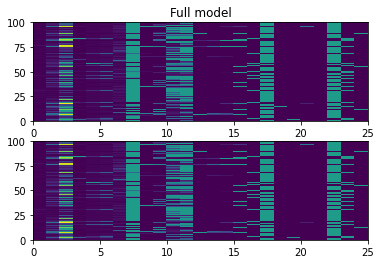

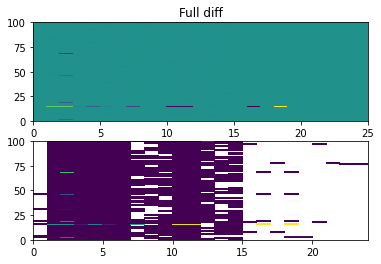

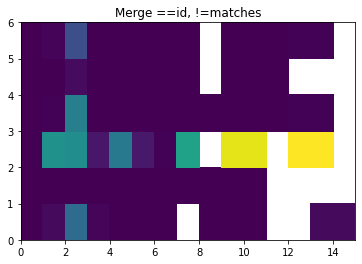

In [71]:
# keep = ['id', 'label', 'matches', 'radius']
# m = pd.merge(minasFiModDF[keep], mfogModelDF[keep], on='id', how='left')#[['id', 'og', 'label']]
# m = pd.merge(modelDF, mfogModelDF, on='id', how='left')
# diff = m[m['matches_x'] != m['matches_y']]
# diffIds = diff['id']
# a = modelDF[modelDF['id'].isin(diffIds)]
# b = mfogModelDF[mfogModelDF['id'].isin(diffIds)]
# c = compareModelDf(a, b)
# c
compareModelDf(modelDF, mfogModelDF)

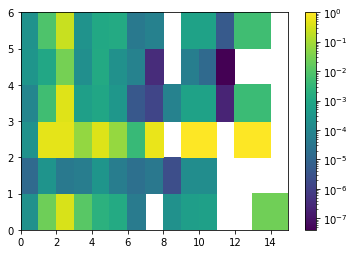

,matches,meanDistance,radius,c0,c1,c2,c3,c4,c5,c7,c8,c9,c13,c15,c16
2,0.000208,0.023899,0.346490,0.011759,0.002139,0.001220,0.000044,NaN,0.000207,0.000528,0.000597,NaN,NaN,0.024631,0.02463
3,0.000014,0.000264,0.000041,0.000050,0.000288,0.000052,0.000021,3.703559e-05,0.000002,0.000162,0.000162,NaN,NaN,NaN,NaN
15,0.000236,0.501819,0.484938,0.062346,0.405596,0.065906,0.003968,5.769231e-01,NaN,0.959242,0.957681,NaN,1.000000,1.000000,NaN
19,0.000097,0.005594,0.427457,0.000554,0.000978,0.000329,0.000004,1.349468e-06,0.000078,0.000738,0.000745,2.159129e-07,0.004337,0.004337,NaN
31,0.000292,0.001054,0.028357,0.000187,0.001152,0.000204,0.000077,3.239622e-07,NaN,0.000055,0.000013,4.070879e-08,NaN,NaN,NaN
46,0.000236,0.008409,0.240321,0.000259,0.001099,0.001215,0.000039,6.655478e-05,NaN,0.000748,0.000750,4.843307e-06,0.005474,0.005474,NaN


In [35]:
d = c[c != 0]
d = d.abs().dropna(axis=1, how='all')
dmin = d.min().min()
g = plt.pcolor(d, norm=LogNorm(vmin=dmin, vmax=1), vmin=dmin, vmax=1)
plt.colorbar()
plt.show()
d

In [32]:
# 4   rows, sum = 0.48987752999999 # if(m = 0) c = 0v, 100iter
# 49  rows, sum = 0.5841500099999999 22 iter, 9.974149e-06 better)
# 4   rows, sum = 0.4898775299999999 73 iter, 0.000000e+00 better)
# 4   rows, sum = 0.58113909, resetCluster, 73 iter, 0.000000e+00 better)
# 100 rows, sum = 6.675610216999999, skip radius update, 74 iter, 0.000000e+00 better)
# 6   rows, sum = 0.5410391699999999, skip radius update rst clus, 74 iter, 0.000000e+00 better)
d['meanDistance'].abs().sum()

0.541039146115394

In [20]:
d.min().min()

4.070879090709373e-08

In [21]:
newMatDF = getMatchesDf('../../out/minas-og/2020-07-22T21-46-01.167/matches.csv')
diffMinasMfog(examplesDf, minasDF, newMatDF)

### Minas

examples  (653457, 25)
matches   (653457, 9)
Confusion Matrix
Classes (act)       A       N assigned class     max
Labels (pred)                                       
-               19677     340              A   19677
N              427502  205938              A  427502
Total examples     653457
Total matches      653457
Hits               205938 ( 31.515157%)
Misses             447519 ( 68.484843%)
Hits + Misses      653457 (100.000000%)


### Mfog

examples  (653457, 25)
matches   (653457, 9)
Confusion Matrix
Classes (act)       A       N assigned class     max
Labels (pred)                                       
-               19614     319              A   19614
N              427565  205959              A  427565
Total examples     653457
Total matches      653457
Hits               205959 ( 31.518371%)
Misses             447498 ( 68.481629%)
Hits + Misses      653457 (100.000000%)


### Diff

            id j_clL     j_clR j_L       j_D c_clL     c_clR c_L       c_

,#pointId_x,clusterLabel_x,clusterCategory_x,clusterId_x,clusterRadius_x,label_x,distance_x,secondDistance_x,id,#pointId_y,clusterLabel_y,clusterCategory_y,clusterId_y,clusterRadius_y,label_y,distance_y,secondDistance_y
1178,1178,N,normal,0,0.503355,N,0.481878,0.493688,1178,1178,N,normal,0,0.468740,-,0.472784,0.507546
2196,2196,N,normal,0,0.786041,N,0.459109,0.469395,2196,2196,N,normal,0,0.398849,-,0.457938,0.466172
15675,15675,N,normal,0,0.082241,-,0.088899,0.089509,15675,15675,N,normal,0,0.099042,N,0.093019,0.093167
15718,15718,N,normal,0,0.132058,-,0.167713,0.251604,15718,15718,N,normal,0,0.278194,N,0.239603,0.251831
15893,15893,N,normal,0,0.685839,N,0.542879,0.545018,15893,15893,N,normal,0,0.537506,-,0.538066,0.543119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644933,644933,N,normal,0,0.183655,-,0.309602,0.342500,644933,644933,N,normal,0,0.515985,N,0.312972,0.341759
647565,647565,N,normal,0,0.560968,N,0.324052,0.335694,647565,647565,N,normal,0,0.326379,-,0.329324,0.335197
647954,647954,N,normal,0,0.257275,-,0.260524,0.268114,647954,647954,N,normal,0,0.468740,N,0.253883,0.262922
649337,649337,N,normal,0,1.257792,N,0.771496,0.771578,649337,649337,N,normal,0,0.751851,-,0.765419,0.771648


,matches,meanDistance,radius,c0,c1,c2,c3,c4,c5,c6,...,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21
0,0.003139,0.003567,0.125068,3.174582e-04,0.000022,0.000763,0.002462,0.003623,NaN,0.002512,...,NaN,NaN,0.003623,NaN,NaN,NaN,NaN,0.003623,NaN,NaN
1,0.000583,0.013876,0.000590,3.360920e-04,0.000154,0.002828,0.007343,0.003541,2.723533e-05,0.005149,...,NaN,NaN,0.002833,NaN,NaN,NaN,NaN,0.002833,NaN,NaN
2,0.000014,0.001023,0.000562,9.159999e-04,0.000256,0.000489,0.000003,NaN,1.414742e-05,NaN,...,NaN,NaN,NaN,NaN,0.001681,NaN,NaN,NaN,0.001681,NaN
3,0.000111,0.000255,0.000078,1.305654e-04,0.000024,0.000613,0.000073,0.000293,1.795379e-05,NaN,...,NaN,0.001175,NaN,NaN,NaN,NaN,NaN,NaN,0.001175,NaN
4,0.000250,0.000398,0.000966,8.986134e-08,0.000025,0.000003,0.000361,0.001109,NaN,0.000108,...,NaN,NaN,0.001091,NaN,NaN,NaN,NaN,0.001091,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.003792,NaN,0.032889,8.749700e-05,0.022020,0.028887,0.077752,1.000000,NaN,NaN,...,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN,NaN
96,0.000014,0.007160,0.002752,1.213937e-03,0.000126,NaN,0.002026,0.021277,2.127660e-02,0.019389,...,0.00555,NaN,NaN,NaN,NaN,0.015726,NaN,0.021277,NaN,NaN
97,0.000014,0.000086,0.000190,5.528321e-07,0.000048,0.000060,0.000093,0.001370,8.245153e-07,0.000176,...,NaN,NaN,0.001370,NaN,NaN,NaN,NaN,0.001370,NaN,NaN
98,0.000042,0.002238,0.000910,7.785078e-06,0.000042,0.000196,0.000133,0.003268,2.823810e-05,0.001188,...,NaN,NaN,0.003268,NaN,NaN,NaN,NaN,0.003268,NaN,NaN


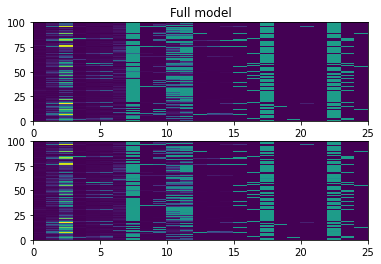

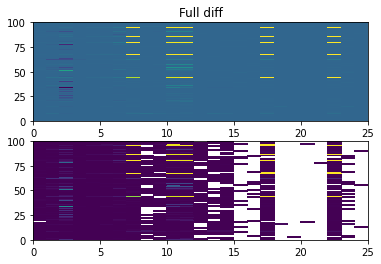

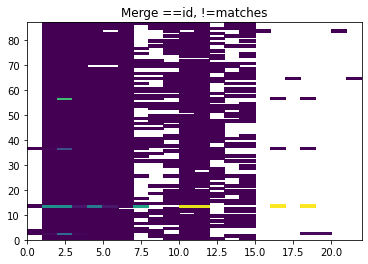

In [73]:
newIni = getModelDf('../../out/minas-og/2020-07-22T21-46-01.167/model/0_initial.csv')
newFin = getModelDf('../../out/minas-og/2020-07-22T21-46-01.167/model/653457_final.csv')
compareModelDf(modelDF, newIni)
# compareModelDf(newIni, newFin)
# compareModelDf(mfogModelDF, newIni)

In [15]:
%history -g -f jupyter_hist.py